In [1]:
# Load the data from the first sheet to inspect its contents
import pandas as pd

# Replace 'file_path.xlsx' with the path to your Excel file
data = pd.read_excel('../data 33.xlsx', sheet_name='Sheet1')
data.head()

,State,Belongs to State,Belongs to Other State,Belongs to Other Country
0,Andaman & Nicobar Islands,64,0,21
1,Andhra Pradesh,1771,212,5
2,Arunachal Pradesh,109,42,0
3,Assam,2721,48,33
4,Bihar,7188,183,4


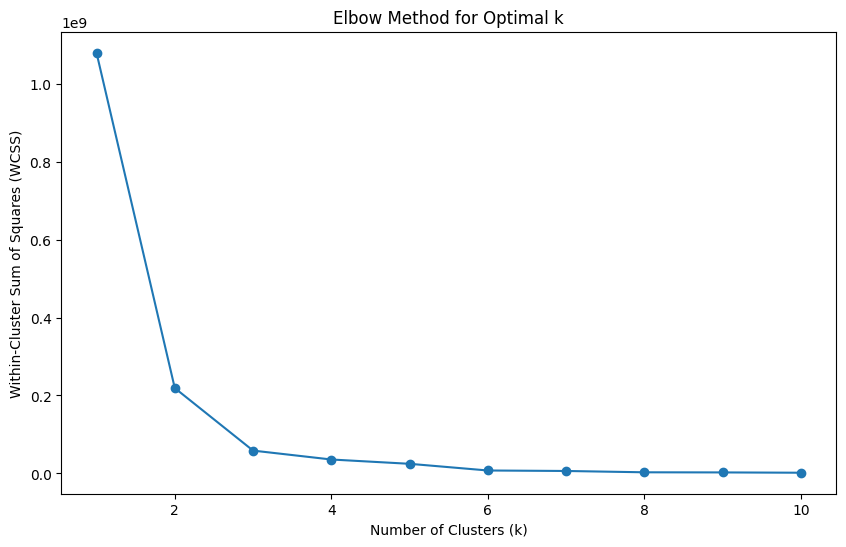

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting the numerical columns for clustering
data_for_clustering = data[['Belongs to State', 'Belongs to Other State', 'Belongs to Other Country']]

# Calculate WCSS for different numbers of clusters
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_for_clustering)
    wcss.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

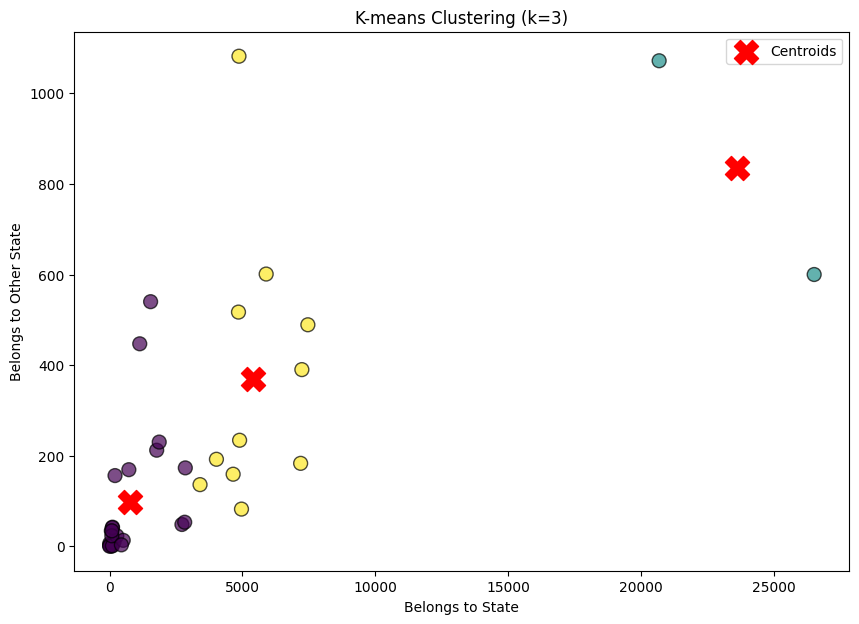

In [3]:
# Applying k-means clustering with the chosen number of clusters (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_for_clustering)

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(data['Belongs to State'], data['Belongs to Other State'], c=data['Cluster'], cmap='viridis', s=100, marker='o', edgecolor='k', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Belongs to State')
plt.ylabel('Belongs to Other State')
plt.title('K-means Clustering (k=3)')
plt.legend()
plt.show()


In [1]:
# Given parameters
swap_time_per_battery = 5 / 60  # Swap time in hours (5 minutes)
num_slots = 8  # Number of swapping slots
battery_charging_time = 3  # Charging time in hours
total_batteries = 40  # Total batteries available

# Calculating service rate (mu)
service_rate_per_slot = 1 / swap_time_per_battery  # vehicles per hour per slot
total_service_rate = service_rate_per_slot * num_slots  # total service rate

# Using queuing theory to calculate the maximum arrival rate (lambda)
# Assuming a target utilization rate (rho) that allows efficient operations.
# Let's assume a maximum utilization of 80% (0.8) to avoid excessive waiting.

target_utilization = 0.8
arrival_rate = target_utilization * total_service_rate  # Maximum arrival rate at 80% utilization

# Calculating other outputs: expected waiting time in queue and system, queue length
from scipy.stats import poisson

# M/M/s Model: Calculating probability of all servers being busy (P0) and other outputs
def calculate_mm_s_metrics(arrival_rate, service_rate, num_servers):
    # Traffic intensity per server
    rho = arrival_rate / (num_servers * service_rate)
    
    # P0 calculation for M/M/s model (probability that all servers are idle)
    sum_terms = sum([(arrival_rate / service_rate) ** n / poisson.pmf(n, num_servers * service_rate) for n in range(num_servers)])
    P0 = 1 / (sum_terms + ((arrival_rate / service_rate) ** num_servers / (poisson.pmf(num_servers, num_servers * service_rate) * (1 - rho))))
    
    # Expected queue length Lq (average number of vehicles in queue)
    Lq = (P0 * ((arrival_rate / service_rate) ** num_servers) * rho) / ((1 - rho) ** 2)
    
    # Expected waiting time in queue Wq
    Wq = Lq / arrival_rate  # in hours
    
    # Expected number of vehicles in system Ls (queue + being served)
    Ls = Lq + (arrival_rate / service_rate)
    
    # Expected time in system Ws (waiting + service time)
    Ws = Ls / arrival_rate  # in hours
    
    return {
        "rho": rho,  # Utilization
        "P0": P0,  # Probability all servers are idle
        "Lq": Lq,  # Average number of vehicles in queue
        "Wq": Wq * 60,  # Waiting time in queue in minutes
        "Ls": Ls,  # Average number of vehicles in system
        "Ws": Ws * 60,  # Total time in system in minutes
        "arrival_rate": arrival_rate * 60  # Maximum vehicle arrivals per hour
    }

# Calculate metrics
queue_metrics = calculate_mm_s_metrics(arrival_rate, service_rate_per_slot, num_slots)
queue_metrics


{'rho': 0.8000000000000002,
 'P0': 1.883891414027831e-42,
 'Lq': 1.0605365837777805e-34,
 'Wq': 8.285442060763909e-35,
 'Ls': 6.400000000000001,
 'Ws': 5.000000000000001,
 'arrival_rate': 4608.000000000001}

Number of Batteries Required: 26
Number of Chargers Required: 4
Total Setup Cost: ₹1233500.0


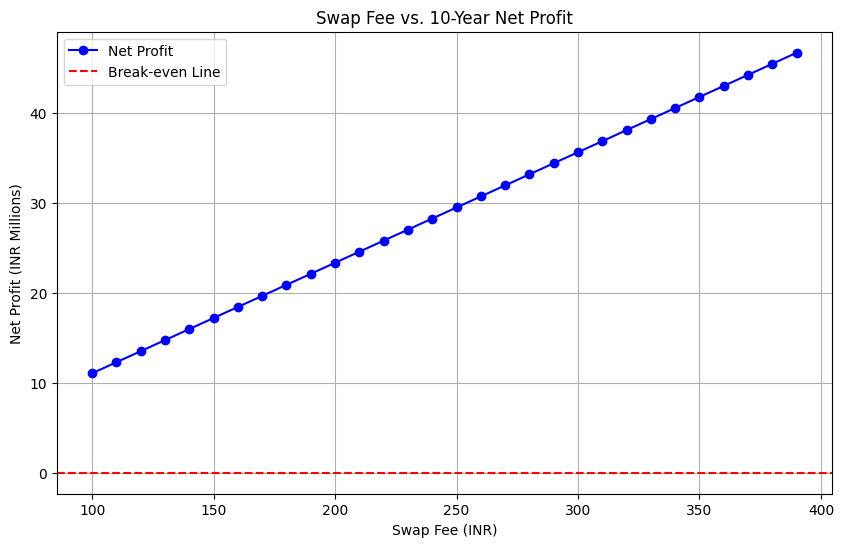

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Base Data
vehicles_per_hour = np.array([1, 1, 0, 0, 0, 1, 1, 2, 4, 4, 5, 5, 6, 5, 10, 3, 4, 8, 5, 4, 3, 2, 1, 1])
swap_time = 5 / 60  # hours per swap (5 minutes)
charging_time = 3    # hours to charge a battery
battery_cost = 40000  # Cost per battery in INR
charger_cost = 1500   # Cost per charger in INR
land_cost_per_100_sq_m = 75000
land_area_sq_m = 250
service_rate_per_slot = 1 / swap_time  # Vehicles per slot per hour

# Function to calculate number of batteries required
def batteries_required(vehicles_per_hour, charging_time, total_service_rate):
    total_batteries_in_use = 0
    batteries_in_queue = 0
    max_batteries = 0

    for hour, demand in enumerate(vehicles_per_hour):
        # Update battery queue based on demand and service capacity
        if demand > total_service_rate:
            batteries_in_queue += demand - total_service_rate
        else:
            batteries_in_queue = max(0, batteries_in_queue - (total_service_rate - demand))

        # Update batteries in use and check the maximum
        total_batteries_in_use += demand
        max_batteries = max(max_batteries, total_batteries_in_use + batteries_in_queue)

        # Consider battery availability after charging time
        if hour >= charging_time:
            total_batteries_in_use -= vehicles_per_hour[hour - charging_time]

    return max_batteries

# Function to calculate number of chargers required
def chargers_required(batteries_needed, charging_time):
    batteries_per_charger_per_day = 24 / charging_time
    chargers_needed = np.ceil(batteries_needed / batteries_per_charger_per_day)
    return int(chargers_needed)

# Function to calculate setup costs
def calculate_costs(batteries_needed, chargers_needed, land_area_sq_m, land_cost_per_100_sq_m):
    battery_cost_total = batteries_needed * battery_cost
    charger_cost_total = chargers_needed * charger_cost
    land_cost_total = (land_area_sq_m / 100) * land_cost_per_100_sq_m
    return battery_cost_total, charger_cost_total, land_cost_total

# Function to visualize swap fee vs. net profit
def plot_swap_fee_vs_profit(total_cost, swaps_per_year, years=10):
    swap_fees = np.arange(100, 400, 10)  # Swap fee range in INR
    total_swaps = swaps_per_year * years
    revenues = swap_fees * total_swaps
    net_profits = revenues - total_cost

    plt.figure(figsize=(10, 6))
    plt.plot(swap_fees, net_profits / 1e6, marker='o', color='b', label='Net Profit')
    plt.axhline(0, color='r', linestyle='--', label='Break-even Line')
    plt.title("Swap Fee vs. 10-Year Net Profit")
    plt.xlabel("Swap Fee (INR)")
    plt.ylabel("Net Profit (INR Millions)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Adjustable Parameters
num_slots = 8
num_vehicles = 76  # Initially set but can be varied
total_service_rate = num_slots * service_rate_per_slot  # Total service capacity
swaps_per_year = 12300  # 41 swaps per day * 300 days

# Calculations
batteries_needed = batteries_required(vehicles_per_hour, charging_time, total_service_rate)
chargers_needed = chargers_required(batteries_needed, charging_time)
battery_cost_total, charger_cost_total, land_cost_total = calculate_costs(batteries_needed, chargers_needed, land_area_sq_m, land_cost_per_100_sq_m)

# Total setup cost
total_setup_cost = battery_cost_total + charger_cost_total + land_cost_total

# Plot results
print(f"Number of Batteries Required: {batteries_needed}")
print(f"Number of Chargers Required: {chargers_needed}")
print(f"Total Setup Cost: ₹{total_setup_cost}")

# Visualize Swap Fee vs. Net Profit
plot_swap_fee_vs_profit(total_setup_cost, swaps_per_year)


Supported Vehicles with 25 Batteries: (14, 26)
Number of Chargers Required: 4
Total Initial Setup Cost: ₹1193500.0
Annual Operational Cost: ₹1529400
Present Value of Operational Costs (10 years): ₹11809621.40069526
Required Swap Fee for Breakeven: ₹105.72


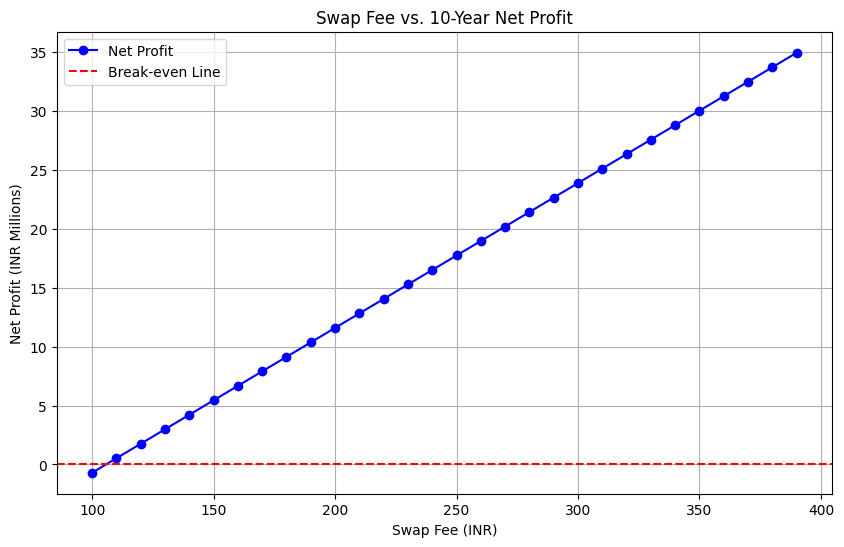

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Initial Constants
vehicles_per_hour = np.array([1, 1, 0, 0, 0, 1, 1, 2, 4, 4, 5, 5, 6, 5, 10, 3, 4, 8, 5, 4, 3, 2, 1, 1])
swap_time = 5 / 60  # hours per swap (5 minutes)
charging_time = 3    # hours to charge a battery
battery_cost = 40000  # Cost per battery in INR
charger_cost = 1500   # Cost per charger in INR
land_cost_per_100_sq_m = 75000
land_area_sq_m = 250
service_rate_per_slot = 1 / swap_time  # Vehicles per slot per hour
swaps_per_year = 12300  # 41 swaps per day * 300 days
years = 10  # Planning horizon for the station

# Operational Costs (Annual)
worker_salaries = 720000  # Annual worker salaries in INR
maintenance_cost = 50000  # Annual maintenance cost in INR
backup_power_cost = 36500  # Annual backup power cost in INR
battery_replacement_cost = 600000  # Annual battery replacement cost in INR
miscellaneous_cost = 30000  # Annual miscellaneous cost in INR
depreciation_cost = 92900  # Annual depreciation cost in INR
discount_rate = 0.05  # Discount rate for present value calculation

# Function to calculate the number of vehicles supported based on fixed number of batteries
def vehicles_supported_by_batteries(fixed_batteries, vehicles_per_hour, charging_time, total_service_rate):
    total_batteries_in_use = 0
    batteries_in_queue = 0
    max_supported_vehicles = 0

    for hour, demand in enumerate(vehicles_per_hour):
        if demand > total_service_rate:
            batteries_in_queue += demand - total_service_rate
        else:
            batteries_in_queue = max(0, batteries_in_queue - (total_service_rate - demand))

        total_batteries_in_use += demand
        max_supported_vehicles = max(max_supported_vehicles, total_batteries_in_use + batteries_in_queue)

        if hour >= charging_time:
            total_batteries_in_use -= vehicles_per_hour[hour - charging_time]

        # Check if max vehicles exceed the battery limit
        if max_supported_vehicles > fixed_batteries:
            return hour, max_supported_vehicles  # Return hour at which demand exceeds available batteries

    return max_supported_vehicles

# Function to calculate number of chargers required
def chargers_required(batteries_needed, charging_time):
    batteries_per_charger_per_day = 24 / charging_time
    chargers_needed = np.ceil(batteries_needed / batteries_per_charger_per_day)
    return int(chargers_needed)

# Function to calculate setup costs
def calculate_initial_costs(batteries_needed, chargers_needed, land_area_sq_m, land_cost_per_100_sq_m):
    battery_cost_total = batteries_needed * battery_cost
    charger_cost_total = chargers_needed * charger_cost
    land_cost_total = (land_area_sq_m / 100) * land_cost_per_100_sq_m
    return battery_cost_total, charger_cost_total, land_cost_total

# Function to calculate operational costs
def calculate_operational_costs(worker_salaries, maintenance_cost, backup_power_cost, battery_replacement_cost, miscellaneous_cost, depreciation_cost, years, discount_rate):
    annual_cost = (worker_salaries + maintenance_cost + backup_power_cost +
                   battery_replacement_cost + miscellaneous_cost + depreciation_cost)
    # Present value of operational costs over the planning period
    pv_operational_costs = annual_cost * ((1 - (1 + discount_rate) ** -years) / discount_rate)
    return annual_cost, pv_operational_costs

# Function to calculate the required swap fee for profitability
def calculate_swap_fee_for_profit(total_setup_cost, pv_operational_costs, swaps_per_year, years):
    required_revenue = total_setup_cost + pv_operational_costs
    total_swaps = swaps_per_year * years
    swap_fee = required_revenue / total_swaps
    return swap_fee

# Function to visualize swap fee vs. net profit
def plot_swap_fee_vs_profit(total_cost, swaps_per_year, years=10):
    swap_fees = np.arange(100, 400, 10)  # Swap fee range in INR
    total_swaps = swaps_per_year * years
    revenues = swap_fees * total_swaps
    net_profits = revenues - total_cost

    plt.figure(figsize=(10, 6))
    plt.plot(swap_fees, net_profits / 1e6, marker='o', color='b', label='Net Profit')
    plt.axhline(0, color='r', linestyle='--', label='Break-even Line')
    plt.title("Swap Fee vs. 10-Year Net Profit")
    plt.xlabel("Swap Fee (INR)")
    plt.ylabel("Net Profit (INR Millions)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Adjustable Parameters
num_slots = 8  # Number of battery swapping slots
total_service_rate = num_slots * service_rate_per_slot  # Total service capacity

# Fixed batteries to test for supported vehicle capacity
fixed_batteries = 25

# Calculations
supported_vehicles = vehicles_supported_by_batteries(fixed_batteries, vehicles_per_hour, charging_time, total_service_rate)
chargers_needed = chargers_required(fixed_batteries, charging_time)
battery_cost_total, charger_cost_total, land_cost_total = calculate_initial_costs(fixed_batteries, chargers_needed, land_area_sq_m, land_cost_per_100_sq_m)
initial_setup_cost = battery_cost_total + charger_cost_total + land_cost_total

# Operational costs calculation
annual_operational_cost, pv_operational_costs = calculate_operational_costs(
    worker_salaries, maintenance_cost, backup_power_cost, battery_replacement_cost,
    miscellaneous_cost, depreciation_cost, years, discount_rate
)

# Total cost over the planning period
total_cost = initial_setup_cost + pv_operational_costs

# Calculate swap fee for breakeven
swap_fee = calculate_swap_fee_for_profit(initial_setup_cost, pv_operational_costs, swaps_per_year, years)

# Plot results
print(f"Supported Vehicles with {fixed_batteries} Batteries: {supported_vehicles}")
print(f"Number of Chargers Required: {chargers_needed}")
print(f"Total Initial Setup Cost: ₹{initial_setup_cost}")
print(f"Annual Operational Cost: ₹{annual_operational_cost}")
print(f"Present Value of Operational Costs (10 years): ₹{pv_operational_costs}")
print(f"Required Swap Fee for Breakeven: ₹{swap_fee:.2f}")

# Visualize Swap Fee vs. Net Profit
plot_swap_fee_vs_profit(total_cost, swaps_per_year)


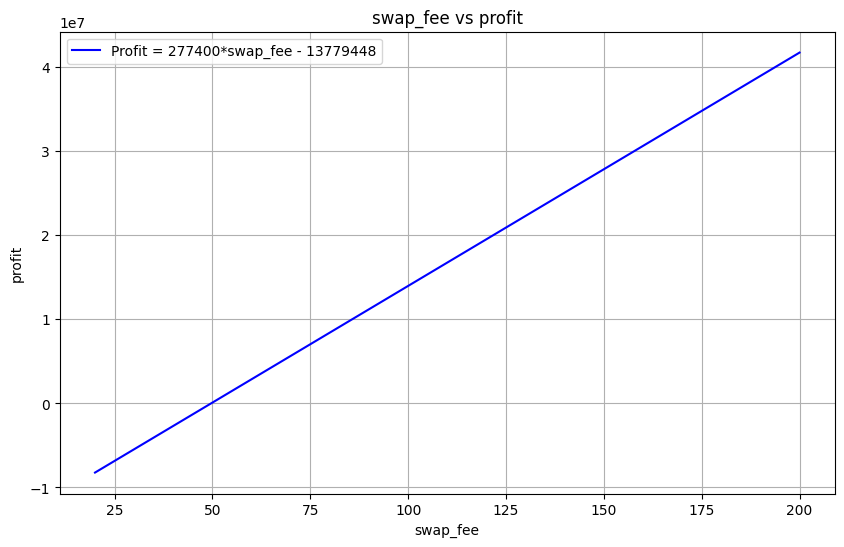

85.7225955299207


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function
def linear_function(swap_fee):
    return 277400 * swap_fee - 13779448

# Generate x values from 20 to 200
swap_fees = np.linspace(20, 200, 100)
y_values = linear_function(swap_fees)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(swap_fees, y_values, label='Profit = 277400*swap_fee - 13779448', color='blue')
plt.xlabel('swap_fee')
plt.ylabel('profit')
plt.title('swap_fee vs profit')
plt.legend()
plt.grid(True)
plt.show()

print((13779448+10000000)/277400)

In [4]:
import numpy as np
from scipy.special import factorial

# Define parameters
service_rate = 20  # Totos per hour (1 battery swap every 3 mins)
charging_slots = 8  # c = number of servers
arrival_rate_off_peak = 5  # off-peak arrival rate in Totos per hour
arrival_rate_peak = 20  # peak arrival rate in Totos per hour

# Range for system capacity K (below original 45)
capacity_range = range(30, 45)  # K values from 30 to 44

# Function to calculate blocking probability for M/M/c/K queue using Erlang B formula
def erlang_b_formula(arrival_rate, service_rate, servers, capacity):
    rho = arrival_rate / service_rate
    blocking_prob = ((rho ** capacity) / factorial(capacity)) / sum((rho ** k) / factorial(k) for k in range(servers + 1))
    return blocking_prob

# Calculate blocking probabilities for each K during off-peak and peak times
blocking_prob_off_peak = []
blocking_prob_peak = []
for K in capacity_range:
    # Off-peak blocking probability
    bp_off_peak = erlang_b_formula(arrival_rate_off_peak, service_rate, charging_slots, K)
    blocking_prob_off_peak.append(bp_off_peak)
    
    # Peak blocking probability
    bp_peak = erlang_b_formula(arrival_rate_peak, service_rate, charging_slots, K)
    blocking_prob_peak.append(bp_peak)

# Organize results
results = {
    "System Capacity (K)": list(capacity_range),
    "Blocking Probability (Off-Peak)": blocking_prob_off_peak,
    "Blocking Probability (Peak)": blocking_prob_peak
}
results

{'System Capacity (K)': [30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44],
 'Blocking Probability (Off-Peak)': [2.5466341860950928e-51,
  2.0537372468508816e-53,
  1.6044822241022513e-55,
  1.215516836441098e-57,
  8.937623797361074e-60,
  6.384016998115013e-62,
  4.433345137579854e-64,
  2.995503471337774e-66,
  1.9707259679853665e-68,
  1.2632858769136939e-70,
  7.895536730710525e-73,
  4.814351665067428e-75,
  2.8656855149210817e-77,
  1.6660962296052784e-79,
  9.466455850030121e-82],
 'Blocking Probability (Peak)': [1.3869025026583449e-33,
  4.4738790408333716e-35,
  1.3980872002604286e-36,
  4.2366278795770516e-38,
  1.2460670234050234e-39,
  3.5601914954429015e-41,
  9.889420820674692e-43,
  2.672816438020218e-44,
  7.033727468474217e-46,
  1.8035198637113342e-47,
  4.5087996592783e-49,
  1.099707233970325e-50,
  2.6183505570721967e-52,
  6.089187342028359e-54,
  1.3839062140973733e-55]}

In [9]:
# Importing required libraries
from typing import Dict
from math import pow

# Constants
DISCOUNT_RATE = 0.05  # Discount rate for NPV calculations

# Helper function to calculate present value (PV) of a series of cash flows
def calculate_present_value(annual_cost: float, years: int = 10, discount_rate: float = DISCOUNT_RATE) -> float:
    pv = annual_cost * ((1 - pow(1 + discount_rate, -years)) / discount_rate)
    return pv

# 1. Function to calculate initial setup cost for the battery swapping station
def calculate_swapping_station_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost"] +
        params["charger_cost"] +
        params["land_cost"] +
        params["service_vehicle_cost"] +
        params["backup_power_system_cost"] +
        params["battery_management_software_cost"] +
        params["electrical_grid_connection_cost"] +
        params["infrastructure_construction_cost"]
    )
    return initial_cost

# 2. Function to calculate initial setup cost for the home charging setup
def calculate_home_charging_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost_per_vehicle"] +
        params["charger_cost_per_vehicle"] +
        params["installation_cost_per_charger"] +
        params["miscellaneous_initial_costs"]
    )
    return initial_cost

# 3. Function to calculate annual operational costs for the battery swapping station
def calculate_swapping_station_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["maintenance_cost"] +
        params["worker_salaries"] +
        params["backup_power_cost"] +
        params["battery_replacement_cost"] +
        params["miscellaneous_operational_costs"] +
        params["depreciation_costs"]
    )
    return annual_cost

# 4. Function to calculate annual operational costs for the home charging setup
def calculate_home_charging_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["battery_replacement_cost_per_vehicle"] +
        params["electricity_cost_per_vehicle"] +
        params["maintenance_cost"] +
        params["miscellaneous_operational_costs"]
    )
    return annual_cost

# 5. Function to calculate total 10-year cost for each setup (initial cost + present value of operational costs)
def calculate_total_10_year_cost(initial_cost: float, annual_operational_cost: float, years: int = 10) -> float:
    operational_cost_pv = calculate_present_value(annual_operational_cost, years)
    total_cost = initial_cost + operational_cost_pv
    return total_cost

# 6. Function to calculate profit based on swap fee, total annual swaps, and total 10-year cost
def calculate_profit(swap_fee: float, total_annual_swaps: int, total_10_year_cost: float) -> float:
    total_revenue = swap_fee * total_annual_swaps
    profit = total_revenue - total_10_year_cost
    return profit

# 7. Function to calculate the break-even swap fee based on the total 10-year cost and desired profit
def calculate_break_even_swap_fee(total_10_year_cost: float, total_annual_swaps: int, desired_profit: float = 0) -> float:
    break_even_fee = (total_10_year_cost + desired_profit) / total_annual_swaps
    return break_even_fee

# Example Usage
# Define all cost parameters
swapping_station_params = {
    "battery_cost": 50000,
    "charger_cost": 15000,
    "land_cost": 30000,
    "service_vehicle_cost": 10000,
    "backup_power_system_cost": 20000,
    "battery_management_software_cost": 8000,
    "electrical_grid_connection_cost": 5000,
    "infrastructure_construction_cost": 25000,
    "maintenance_cost": 5000,
    "worker_salaries": 30000,
    "backup_power_cost": 2000,
    "battery_replacement_cost": 10000,
    "miscellaneous_operational_costs": 2000,
    "depreciation_costs": 5000
}

home_charging_params = {
    "battery_cost_per_vehicle": 20000,
    "charger_cost_per_vehicle": 500,
    "installation_cost_per_charger": 200,
    "miscellaneous_initial_costs": 1000,
    "battery_replacement_cost_per_vehicle": 3000,
    "electricity_cost_per_vehicle": 1000,
    "maintenance_cost": 500,
    "miscellaneous_operational_costs": 200
}

# Define other inputs
total_annual_swaps = 5000
desired_profit = 10000

# Calculate costs for battery swapping station
initial_setup_cost_swapping = calculate_swapping_station_setup_cost(swapping_station_params)
annual_operational_cost_swapping = calculate_swapping_station_annual_operational_cost(swapping_station_params)
total_10_year_cost_swapping = calculate_total_10_year_cost(initial_setup_cost_swapping, annual_operational_cost_swapping)

# Calculate costs for home charging setup
initial_setup_cost_home = calculate_home_charging_setup_cost(home_charging_params)
annual_operational_cost_home = calculate_home_charging_annual_operational_cost(home_charging_params)
total_10_year_cost_home = calculate_total_10_year_cost(initial_setup_cost_home, annual_operational_cost_home)

# Calculate profit and break-even swap fee
swap_fee = 50  # Example swap fee for testing
profit = calculate_profit(swap_fee, total_annual_swaps, total_10_year_cost_swapping)
break_even_fee = calculate_break_even_swap_fee(total_10_year_cost_swapping, total_annual_swaps, desired_profit)

# Print results
print("Initial Setup Cost (Swapping Station):", initial_setup_cost_swapping)
print("Annual Operational Cost (Swapping Station):", annual_operational_cost_swapping)
print("Total 10-Year Cost (Swapping Station):", total_10_year_cost_swapping)
print("Profit with swap fee of", swap_fee, ":", profit)
print("Break-Even Swap Fee (desired profit =", desired_profit, "):", break_even_fee)


Initial Setup Cost (Swapping Station): 163000
Annual Operational Cost (Swapping Station): 54000
Total 10-Year Cost (Swapping Station): 579973.6861759801
Profit with swap fee of 50 : -329973.68617598014
Break-Even Swap Fee (desired profit = 10000 ): 117.99473723519603


In [ ]:
# Importing required libraries
from typing import Dict
from math import pow

# Constants
DISCOUNT_RATE = 0.05  # Discount rate for NPV calculations

# Helper function to calculate present value (PV) of a series of cash flows
def calculate_present_value(annual_cost: float, years: int = 10, discount_rate: float = DISCOUNT_RATE) -> float:
    pv = annual_cost * ((1 - pow(1 + discount_rate, -years)) / discount_rate)
    return pv

# 1. Function to calculate initial setup cost for the battery swapping station
def calculate_swapping_station_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost"] +
        params["charger_cost"] +
        params["land_cost"] +
        params["service_vehicle_cost"] +
        params["backup_power_system_cost"] +
        params["battery_management_software_cost"] +
        params["electrical_grid_connection_cost"] +
        params["infrastructure_construction_cost"]
    )
    return initial_cost

# 2. Function to calculate initial setup cost for the home charging setup
def calculate_home_charging_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost_per_vehicle"] +
        params["charger_cost_per_vehicle"] +
        params["installation_cost_per_charger"] +
        params["miscellaneous_initial_costs"]
    )
    return initial_cost

# 3. Function to calculate annual operational costs for the battery swapping station
def calculate_swapping_station_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["maintenance_cost"] +
        params["worker_salaries"] +
        params["backup_power_cost"] +
        params["battery_replacement_cost"] +
        params["miscellaneous_operational_costs"] +
        params["depreciation_costs"]
    )
    return annual_cost

# 4. Function to calculate annual operational costs for the home charging setup
def calculate_home_charging_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["battery_replacement_cost_per_vehicle"] +
        params["electricity_cost_per_vehicle"] +
        params["maintenance_cost"] +
        params["miscellaneous_operational_costs"]
    )
    return annual_cost

# 5. Function to calculate total 10-year cost for each setup (initial cost + present value of operational costs)
def calculate_total_10_year_cost(initial_cost: float, annual_operational_cost: float, years: int = 10) -> float:
    operational_cost_pv = calculate_present_value(annual_operational_cost, years)
    total_cost = initial_cost + operational_cost_pv
    return total_cost

# 6. Function to calculate profit based on swap fee, total annual swaps, and total 10-year cost
def calculate_profit(swap_fee: float, total_annual_swaps: int, total_10_year_cost: float) -> float:
    total_revenue = swap_fee * total_annual_swaps
    profit = total_revenue - total_10_year_cost
    return profit

# 7. Function to calculate the break-even swap fee based on the total 10-year cost and desired profit
def calculate_break_even_swap_fee(total_10_year_cost: float, total_annual_swaps: int, desired_profit: float = 0) -> float:
    break_even_fee = (total_10_year_cost + desired_profit) / total_annual_swaps
    return break_even_fee

# Example Usage
# Define all cost parameters
swapping_station_params = {
    "battery_cost": 50000,
    "charger_cost": 15000,
    "land_cost": 30000,
    "service_vehicle_cost": 10000,
    "backup_power_system_cost": 20000,
    "battery_management_software_cost": 8000,
    "electrical_grid_connection_cost": 5000,
    "infrastructure_construction_cost": 25000,
    "maintenance_cost": 5000,
    "worker_salaries": 30000,
    "backup_power_cost": 2000,
    "battery_replacement_cost": 10000,
    "miscellaneous_operational_costs": 2000,
    "depreciation_costs": 5000
}

home_charging_params = {
    "battery_cost_per_vehicle": 20000,
    "charger_cost_per_vehicle": 500,
    "installation_cost_per_charger": 200,
    "miscellaneous_initial_costs": 1000,
    "battery_replacement_cost_per_vehicle": 3000,
    "electricity_cost_per_vehicle": 1000,
    "maintenance_cost": 500,
    "miscellaneous_operational_costs": 200
}

# Define other inputs
total_annual_swaps = 5000
desired_profit = 10000

# Calculate costs for battery swapping station
initial_setup_cost_swapping = calculate_swapping_station_setup_cost(swapping_station_params)
annual_operational_cost_swapping = calculate_swapping_station_annual_operational_cost(swapping_station_params)
total_10_year_cost_swapping = calculate_total_10_year_cost(initial_setup_cost_swapping, annual_operational_cost_swapping)

# Calculate costs for home charging setup
initial_setup_cost_home = calculate_home_charging_setup_cost(home_charging_params)
annual_operational_cost_home = calculate_home_charging_annual_operational_cost(home_charging_params)
total_10_year_cost_home = calculate_total_10_year_cost(initial_setup_cost_home, annual_operational_cost_home)

# Calculate profit and break-even swap fee
swap_fee = 50  # Example swap fee for testing
profit = calculate_profit(swap_fee, total_annual_swaps, total_10_year_cost_swapping)
break_even_fee = calculate_break_even_swap_fee(total_10_year_cost_swapping, total_annual_swaps, desired_profit)

# Print results
print("Initial Setup Cost (Swapping Station):", initial_setup_cost_swapping)
print("Annual Operational Cost (Swapping Station):", annual_operational_cost_swapping)
print("Total 10-Year Cost (Swapping Station):", total_10_year_cost_swapping)
print("Profit with swap fee of", swap_fee, ":", profit)
print("Break-Even Swap Fee (desired profit =", desired_profit, "):", break_even_fee)


In [24]:
import numpy as np
import math

# Original vehicle demand profile (total 76 vehicles)
vehicles_per_hour = np.array([1, 1, 0, 0, 0, 1, 1, 2, 4, 4, 5, 5, 6, 5, 10, 3, 4, 8, 5, 4, 3, 2, 1, 1])
swap_time = 0.1  # Hours per swap (6 minutes)
charging_time = 6  # Hours to fully charge
max_wait_time = 0.083  # Hours (5 minutes)
num_slots = 8  # Number of slots for simultaneous swaps

def scale_vehicle_demand(vehicles_per_hour, target_vehicle_count):
    """
    Scale the vehicles_per_hour array to match a new target vehicle count.
    """
    current_vehicle_count = vehicles_per_hour.sum()
    scaling_factor = target_vehicle_count / current_vehicle_count
    scaled_demand = np.round(vehicles_per_hour * scaling_factor).astype(int)
    
    # Adjust the scaled demand to ensure it matches exactly the target vehicle count
    difference = target_vehicle_count - scaled_demand.sum()
    if difference > 0:
        for i in range(difference):
            scaled_demand[i % len(scaled_demand)] += 1
    elif difference < 0:
        for i in range(-difference):
            scaled_demand[i % len(scaled_demand)] -= 1
    
    return scaled_demand

def calculate_batteries_needed(vehicles_per_hour, charging_time, total_service_rate, max_wait_time):
    """
    Calculate the required number of batteries, considering peak hours, allowed wait time, and swap slots.
    """
    total_batteries_in_use = 0
    batteries_in_queue = 0
    max_batteries = 0
    batteries_being_charged = [0] * int(charging_time)  # Track batteries charging each hour

    for hour, demand in enumerate(vehicles_per_hour):
        # Calculate the waiting time based on current queue and demand
        actual_wait_time = max(0, (demand - total_service_rate) / total_service_rate) * swap_time
        
        # If the demand exceeds our service rate and wait time exceeds the max allowed, we need more batteries or slots
        if actual_wait_time > max_wait_time:
            additional_slots_needed = math.ceil((demand - total_service_rate * max_wait_time) / (1 / swap_time))
            num_slots_needed = max(num_slots, additional_slots_needed)
            total_service_rate = num_slots_needed / swap_time  # Update the total service rate

        # Queue management: add batteries in queue if demand exceeds service rate
        if demand > total_service_rate:
            batteries_in_queue += demand - total_service_rate
        else:
            batteries_in_queue = max(0, batteries_in_queue - (total_service_rate - demand))

        # Update batteries in use and track max requirement
        total_batteries_in_use += demand
        max_batteries = max(max_batteries, total_batteries_in_use + batteries_in_queue)

        # Shift charged batteries by 1 hour and return the oldest batch of charged batteries to the pool
        returning_batteries = batteries_being_charged.pop(0)
        total_batteries_in_use -= returning_batteries  # Reduce in-use batteries by the charged amount
        batteries_being_charged.append(demand)  # New batteries going for charging after this hour

    # Return the maximum number of batteries required to meet demand without exceeding the wait time
    return math.ceil(max_batteries)

# Example usage
target_vehicle_count = 1000  # Desired new total vehicle count
scaled_vehicles_per_hour = scale_vehicle_demand(vehicles_per_hour, target_vehicle_count)
print(f"Scaled Vehicles Per Hour: {scaled_vehicles_per_hour}")

# Run the calculation with scaled demand
total_service_rate = num_slots / swap_time
batteries_needed = calculate_batteries_needed(scaled_vehicles_per_hour, charging_time, total_service_rate, max_wait_time)
print(f"Total Batteries Needed: {batteries_needed}")


Scaled Vehicles Per Hour: [ 13  13   0   0   0  13  13  26  53  53  66  66  79  66 132  39  53 105
  66  53  39  26  13  13]
Total Batteries Needed: 567


In [38]:
# Importing required libraries
from typing import Dict
from math import pow, ceil
import numpy as np
import math

# Constants
DISCOUNT_RATE = 0.05  # Discount rate for NPV calculations

# Helper function to calculate present value (PV) of a series of cash flows
def calculate_present_value(annual_cost: float, years: int = 10, discount_rate: float = DISCOUNT_RATE) -> float:
    pv = annual_cost * ((1 - pow(1 + discount_rate, -years)) / discount_rate)
    return pv

# 1. Function to calculate initial setup cost for the battery swapping station
def calculate_swapping_station_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost"] +
        params["charger_cost"] +
        params["land_cost"] +
        params["service_vehicle_cost"] +
        params["backup_power_system_cost"] +
        params["battery_management_software_cost"] +
        params["electrical_grid_connection_cost"] +
        params["infrastructure_construction_cost"]
    )
    print(params)
    return initial_cost

# 2. Function to calculate initial setup cost for the home charging setup
def calculate_home_charging_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost_per_vehicle"] +
        params["charger_cost_per_vehicle"] +
        params["installation_cost_per_charger"] +
        params["miscellaneous_initial_costs"]
    )
    return initial_cost

# 3. Function to calculate annual operational costs for the battery swapping station
def calculate_swapping_station_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["maintenance_cost"] +
        params["worker_salaries"] +
        params["backup_power_cost"] +
        params["battery_replacement_cost"] +
        params["miscellaneous_operational_costs"] +
        params["depreciation_costs"]
    )
    print(params)
    return annual_cost

# 4. Function to calculate annual operational costs for the home charging setup
def calculate_home_charging_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["battery_replacement_cost_per_vehicle"] +
        params["electricity_cost_per_vehicle"] +
        params["maintenance_cost"] +
        params["miscellaneous_operational_costs"]
    )
    return annual_cost

# 5. Function to calculate total 10-year cost for each setup (initial cost + present value of operational costs)
def calculate_total_10_year_cost(initial_cost: float, annual_operational_cost: float, years: int = 10) -> float:
    operational_cost_pv = calculate_present_value(annual_operational_cost, years)
    total_cost = initial_cost + operational_cost_pv
    return total_cost

# 6. Function to calculate profit based on swap fee, total annual swaps, and total 10-year cost
def calculate_profit(swap_fee: float, total_annual_swaps: int, total_10_year_cost: float) -> float:
    total_revenue = swap_fee * total_annual_swaps * 10
    profit = total_revenue - total_10_year_cost
    return profit

# 7. Function to calculate the break-even swap fee based on the total 10-year cost and desired profit
def calculate_break_even_swap_fee(total_10_year_cost: float, total_annual_swaps: int, desired_profit: float = 0) -> float:
    break_even_fee = (total_10_year_cost + desired_profit) / (total_annual_swaps*10)
    return break_even_fee

# 8. 

def scale_vehicle_demand(vehicles_per_hour, target_vehicle_count):
    """
    Scale the vehicles_per_hour array to match a new target vehicle count.
    """
    current_vehicle_count = vehicles_per_hour.sum()
    scaling_factor = target_vehicle_count / current_vehicle_count
    scaled_demand = np.round(vehicles_per_hour * scaling_factor).astype(int)
    
    # Adjust the scaled demand to ensure it matches exactly the target vehicle count
    difference = target_vehicle_count - scaled_demand.sum()
    if difference > 0:
        for i in range(difference):
            scaled_demand[i % len(scaled_demand)] += 1
    elif difference < 0:
        for i in range(-difference):
            scaled_demand[i % len(scaled_demand)] -= 1
    
    return scaled_demand

# 9.
def calculate_batteries_needed(vehicles_per_hour, charging_time, total_service_rate, max_wait_time):
    """
    Calculate the required number of batteries, considering peak hours, allowed wait time, and swap slots.
    """
    total_batteries_in_use = 0
    batteries_in_queue = 0
    max_batteries = 0
    batteries_being_charged = [0] * int(charging_time)  # Track batteries charging each hour

    for hour, demand in enumerate(vehicles_per_hour):
        # Calculate the waiting time based on current queue and demand
        actual_wait_time = max(0, (demand - total_service_rate) / total_service_rate) * swap_time
        
        # If the demand exceeds our service rate and wait time exceeds the max allowed, we need more batteries or slots
        if actual_wait_time > max_wait_time:
            additional_slots_needed = math.ceil((demand - total_service_rate * max_wait_time) / (1 / swap_time))
            num_slots_needed = max(num_slots, additional_slots_needed)
            total_service_rate = num_slots_needed / swap_time  # Update the total service rate

        # Queue management: add batteries in queue if demand exceeds service rate
        if demand > total_service_rate:
            batteries_in_queue += demand - total_service_rate
        else:
            batteries_in_queue = max(0, batteries_in_queue - (total_service_rate - demand))

        # Update batteries in use and track max requirement
        total_batteries_in_use += demand
        max_batteries = max(max_batteries, total_batteries_in_use + batteries_in_queue)

        # Shift charged batteries by 1 hour and return the oldest batch of charged batteries to the pool
        returning_batteries = batteries_being_charged.pop(0)
        total_batteries_in_use -= returning_batteries  # Reduce in-use batteries by the charged amount
        batteries_being_charged.append(demand)  # New batteries going for charging after this hour

    # Return the maximum number of batteries required to meet demand without exceeding the wait time
    return math.ceil(max_batteries)



# Example Usage
# Define all cost parameters

# Original vehicle demand profile (total 76 vehicles)
vehicles_per_hour = np.array([1, 1, 0, 0, 0, 1, 1, 2, 4, 4, 5, 5, 6, 5, 10, 3, 4, 8, 5, 4, 3, 2, 1, 1])
swap_time = 0.25  # Hours per swap (6 minutes)
charging_time = 6  # Hours to fully charge
max_wait_time = 0.083  # Hours (5 minutes)
num_slots = 8  # Number of slots for simultaneous swaps
number_of_chargers = 13
num_workers = 4
lead_acid_battery_life=1
lithium_ion_battery_life=3

# Example usage
target_vehicle_count = 76  # Desired new total vehicle count
scaled_vehicles_per_hour = scale_vehicle_demand(vehicles_per_hour, target_vehicle_count)

# Run the calculation with scaled demand
total_service_rate = num_slots / swap_time
batteries_needed = calculate_batteries_needed(scaled_vehicles_per_hour, charging_time, total_service_rate, max_wait_time)+4


swapping_station_params = {
    "battery_cost": 40000 * batteries_needed,
    "charger_cost": 1500 * number_of_chargers,
    "land_cost": 187500,
    "service_vehicle_cost": 120000,
    "backup_power_system_cost": 70000,
    "battery_management_software_cost": 295000,
    "electrical_grid_connection_cost": 50000,
    "infrastructure_construction_cost": 300000,
    "maintenance_cost": 50000,
    "worker_salaries": 15000 * num_workers * 12,
    "battery_replacement_cost": 600000,
    "backup_power_cost": 36500,
    "miscellaneous_operational_costs": 30000,
    "depreciation_costs": 92900
}

home_charging_params = {
    "battery_cost_per_vehicle": 32000,
    "charger_cost_per_vehicle": 1500,
    "installation_cost_per_charger": 1000,
    "miscellaneous_initial_costs": 5000,
    "battery_replacement_cost_per_vehicle": 32000/lead_acid_battery_life,
    "electricity_cost_per_vehicle": 6000,
    "maintenance_cost": 1000,
    "miscellaneous_operational_costs": 2000
}

# Define other inputs
total_annual_swaps = target_vehicle_count * 365 
desired_profit = 0

# Calculate costs for battery swapping station
initial_setup_cost_swapping = calculate_swapping_station_setup_cost(swapping_station_params)
annual_operational_cost_swapping = calculate_swapping_station_annual_operational_cost(swapping_station_params)
total_10_year_cost_swapping = calculate_total_10_year_cost(initial_setup_cost_swapping, annual_operational_cost_swapping)

# Calculate costs for home charging setup
initial_setup_cost_home = calculate_home_charging_setup_cost(home_charging_params)
annual_operational_cost_home = calculate_home_charging_annual_operational_cost(home_charging_params)
total_10_year_cost_home = calculate_total_10_year_cost(initial_setup_cost_home, annual_operational_cost_home)

# Calculate profit and break-even swap fee
swap_fee = 52.81766907244146 # Example swap fee for testing
profit = calculate_profit(swap_fee, total_annual_swaps, total_10_year_cost_swapping)
break_even_fee = calculate_break_even_swap_fee(total_10_year_cost_swapping, total_annual_swaps, desired_profit)


# Print results
print("Total Batteries Required for Daily Demand:", batteries_needed)
print("Initial Setup Cost (Swapping Station):", initial_setup_cost_swapping)
print("Annual Operational Cost (Swapping Station):", annual_operational_cost_swapping)
print("Total 10-Year Cost (Swapping Station):", total_10_year_cost_swapping)
print("Initial Setup Cost (Home Charging):", initial_setup_cost_home)
print("Annual Operational Cost (Hom Charging):", annual_operational_cost_home)
print("Total 10-Year Cost (Home Charging):", total_10_year_cost_home)
print("Profit with swap fee of", swap_fee, ":", profit)
print("Break-Even Swap Fee (desired profit =", desired_profit, "):", break_even_fee)



{'battery_cost': 1800000, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 600000, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900}
{'battery_cost': 1800000, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 600000, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900}
Total Batteries Required for Daily Demand: 45
Initial Setup Cost (Swapping Station): 284